```
# Copyright 2023 by the author(s) of CHI2023 Late Breaking Work
# "Exploring Physiological Correlates of Visual Complexity Adaptation:
# Insights from EDA, ECG, and EEG Data for Adaptation Evaluation in VR
# Adaptive Systems". All rights reserved.
#
# Use of this source code is governed by a GPLv3 license that
# can be found in the LICENSE file.
```

In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

from lbw import get_event_intervals

In [2]:
def load_eda(pid):
    dfEDA = pd.read_csv(f"./data/ID{pid}-EDA.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")
    dfEDA.drop("TimeLsl", axis =1, inplace=True)

    intervals, workloads = get_event_intervals(dfAdaptation)
    for idx, interval in enumerate(intervals):
        dfEDA.loc[(dfEDA['Time'] >= interval[0]) & (dfEDA['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfEDA.loc[(dfEDA['Time'] >= interval[0]) & (dfEDA['Time'] <= interval[1]), 'interval_id'] = idx
    dfEDA = dfEDA[dfEDA['workload'].notna()]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][2]) & (dfEDA.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][4]) & (dfEDA.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][6]) & (dfEDA.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][8]) & (dfEDA.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][10]) & (dfEDA.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfEDA.loc[dfEDA[(dfEDA.Time > dfState['Time'][12]) & (dfEDA.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]
    dfEDA = dfEDA.dropna()
    dfEDA = dfEDA.sort_values(by="Time")
    return dfEDA

def extract_eda_features(pid, df):
    df_features = pd.DataFrame()
    intervals = df.interval_id.unique()
    for interval_id in intervals:
        df_current = df[df.interval_id == interval_id]
        if len(df_current['Value']) < 50:
            df_features = df_features.append(pd.DataFrame.from_dict([{
                'pid': pid,
                'workload': df_current['workload'].iloc[0],
                'interval': interval_id,
            }]))
            continue
        eda_clean, _ = nk.eda_process(df_current['Value'], sampling_rate=250)
        df_features = df_features.append(pd.DataFrame.from_dict([{
            'pid': pid,
            'workload': df_current['workload'].iloc[0],
            'interval': interval_id,
            'tonic_avg': np.mean(eda_clean['EDA_Tonic']),
            'amplitude_avg': np.mean(eda_clean["SCR_Amplitude"]),
            'peaks_num': np.sum(eda_clean['SCR_Peaks']),

        }]))
    return df_features

In [3]:
pid_valid = [4, 5, 7, 9, 10, 11, 12, 13]
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    df = load_eda(pid)
    df_all[pid] = df

100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


In [4]:
df = pd.DataFrame()
for pid in tqdm.tqdm(pid_valid):
    df_features = extract_eda_features(pid, df_all[pid])
    df = df.append(df_features)
df

100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


,pid,workload,interval,tonic_avg,amplitude_avg,peaks_num
0,4,low,0.0,174845.249756,1.584421,4.0
0,4,high,1.0,171962.900679,2.089351,3.0
0,5,low,0.0,204700.507118,5.557244,4.0
0,5,high,1.0,189605.582489,5.190685,4.0
0,5,low,2.0,185861.386674,1.555890,4.0
...,...,...,...,...,...,...
0,13,low,10.0,220832.902538,4.291654,1.0
0,13,high,11.0,250662.773276,9.075797,2.0
0,13,low,12.0,266089.201377,5.371120,4.0
0,13,high,13.0,321911.981977,19.383172,5.0


In [5]:
df['tonic_avg_norm'] = (df['tonic_avg'] - df['tonic_avg'].min()) / (df['tonic_avg'].max() - df['tonic_avg'].min())
df['amplitude_avg_norm'] = (df['amplitude_avg'] - df['amplitude_avg'].min()) / (df['amplitude_avg'].max() - df['amplitude_avg'].min())

In [6]:
df.to_csv("./processed/eda.csv", index=False)

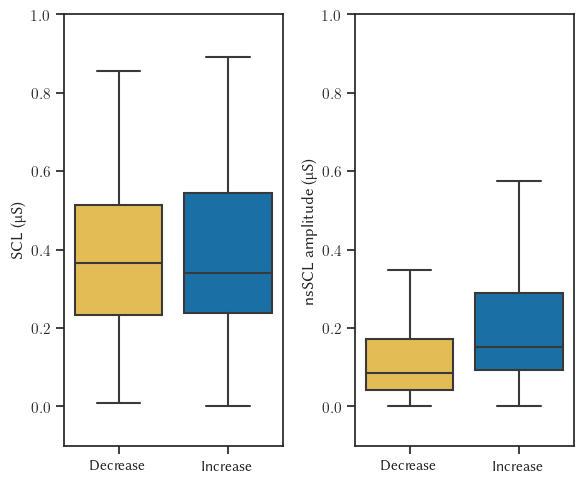

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='tonic_avg_norm', data=df, ax=axes[0], palette=colors, showfliers=False)
sns.boxplot(x='workload', y='amplitude_avg_norm', data=df, ax=axes[1], palette=colors, showfliers=False)

axes[0].set_ylabel('SCL (µS)')
axes[1].set_ylabel('nsSCL amplitude (µS)')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].set_ylim(-.1, 1)
axes[1].set_ylim(-.1, 1)

plt.tight_layout()
plt.savefig('figures/fig1eda.pdf')